In [64]:
from importlib import reload
import pandas as pd
import numpy as np

from itertools import combinations, permutations

import pickle

import os
import glob
import sys
from pathlib import Path

import math
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import sem

from scipy import signal
from scipy.signal import hilbert

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

import lfp.lfp_analysis.LFP_collection as LFP_collection
import lfp.lfp_analysis.preprocessor as preprocessor
import lfp.lfp_analysis.connectivity_wrapper as connect
import lfp.lfp_analysis.plotting as lfplt
import lfp.lfp_analysis.event_extraction as ee

import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.spike_recording as recording
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.pca_trajectories as pca_trajectories


def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

In [2]:
object_spikes = unpickle_this('pilot2/object_control/object_spikes.pkl')
behavior_dict = unpickle_this('pilot2/object_control/object_behavior_dicts.pkl')
object_control_lfp_json = r"C:\Users\megha\UFL Dropbox\Meghan Cum\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Object_Control (phase 7)\lfp_data\lfp_collection.json"

object_collection = LFP_collection.LFPCollection.load_collection(object_control_lfp_json)

In [ ]:
samp_freq = 1000
order = round(samp_freq)
if order % 2 != 0:  # Python uses % for modulo operation
    order = order - 1
print(order)

1000


In [3]:
def calculate_phase_at_frequencies(signal_data, fs, freq_bands):
    """
    Calculate phase at different frequency bands using Hilbert transform
    
    Parameters:
    -----------
    signal_data : array
        Input time series data
    fs : float
        Sampling frequency in Hz
    freq_bands : list of tuples
        List of (low_freq, high_freq) defining frequency bands of interest
        
    Returns:
    --------
    phases : dict
        Dictionary with frequency bands as keys and phase arrays as values
    """
    phases = {}
    
    for low_freq, high_freq in freq_bands:
        # Design a bandpass filter
        nyquist = fs / 2
        low = low_freq / nyquist
        high = high_freq / nyquist
        b, a = signal.butter(2, [low_freq, high_freq], fs = fs, btype='bandpass')
        
        # Apply the filter
        filtered_signal = signal.filtfilt(b, a, x=signal_data)
        
        # Apply Hilbert transform to get analytic signal
        analytic_signal = hilbert(filtered_signal)
        
        # Extract instantaneous phase
        instantaneous_phase = np.angle(analytic_signal)
        
        # Store in dictionary
        band_name = f"{low_freq}-{high_freq}Hz"
        phases[band_name] = instantaneous_phase
    
    return phases



In [68]:
print(behavior_dict.keys())

new_behavior_dict = {}
subject_dict = {}
for rec, data in behavior_dict.items():
    new_key = rec.split('_')[0] + '_' + rec.split('_')[1] + '_merged.rec'
    new_key = new_key.lower()
    new_behavior_dict[new_key] = data
    subject_dict[new_key] = str(int(rec.split('_')[0]) / 10)
print(subject_dict)

dict_keys(['22_object_CTBN.csv', '23_object_TBCN.csv', '31_object_BNTC.csv', '32_object_NBTC.csv', '41_object_BCNT.csv', '44_Object_TCNB.csv'])
{'22_object_merged.rec': '2.2', '23_object_merged.rec': '2.3', '31_object_merged.rec': '3.1', '32_object_merged.rec': '3.2', '41_object_merged.rec': '4.1', '44_object_merged.rec': '4.4'}


In [70]:
for recording, beh_dict in behavior_dict.items():
    filename = recording.split('_')[0]
    for recording in object_collection.recordings:
        if recording.name.split('_')[0] == filename:
            recording.set_event_dict(beh_dict)

novel mouse
novel mouse
novel mouse
novel mouse


c:\Users\megha\Documents\GitHub\diff_fam_social_memory_ephys\lfp\lfp_analysis\event_extraction.py:114: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)


novel mouse
novel mouse
novel mouse
novel mouse
novel mouse
novel mouse
novel mouse
novel mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse
familiar mouse


c:\Users\megha\Documents\GitHub\diff_fam_social_memory_ephys\lfp\lfp_analysis\plotting.py:77: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(np.array(averages), axis=0)


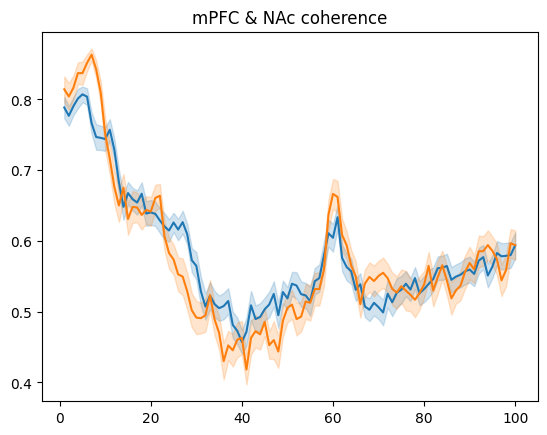

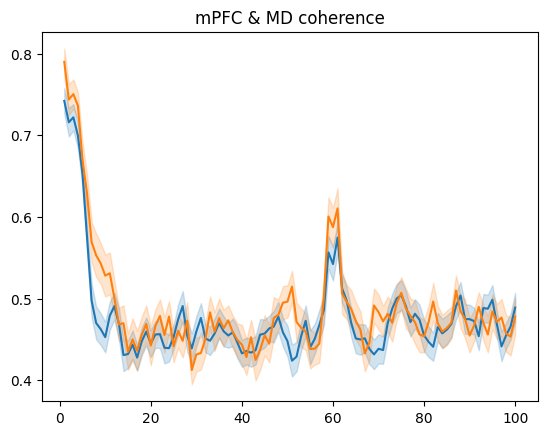

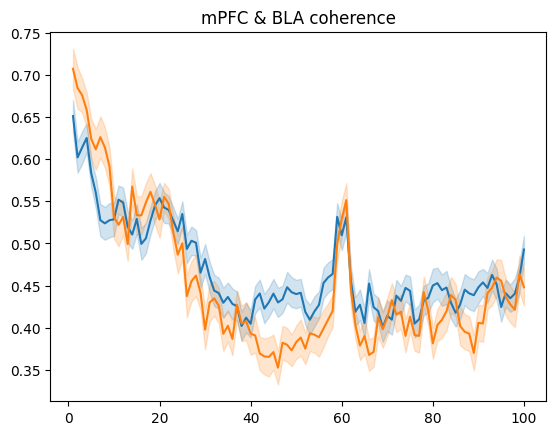

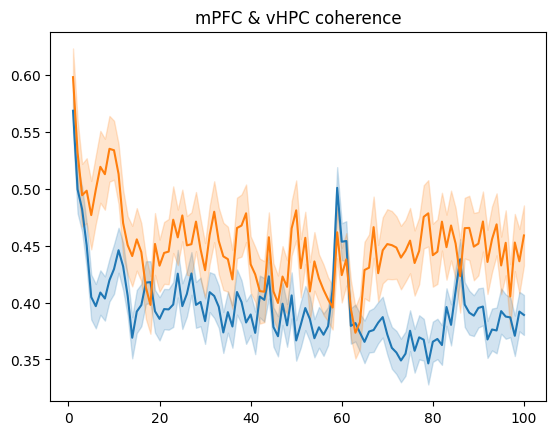

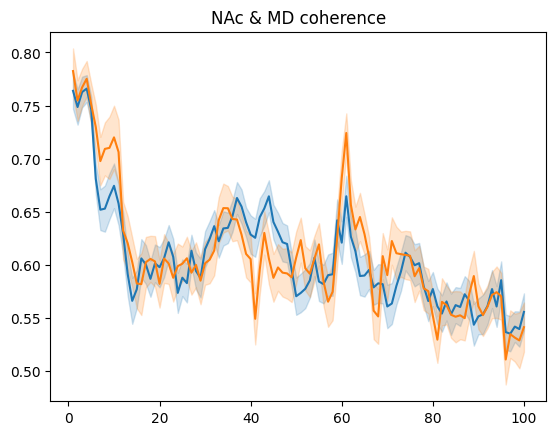

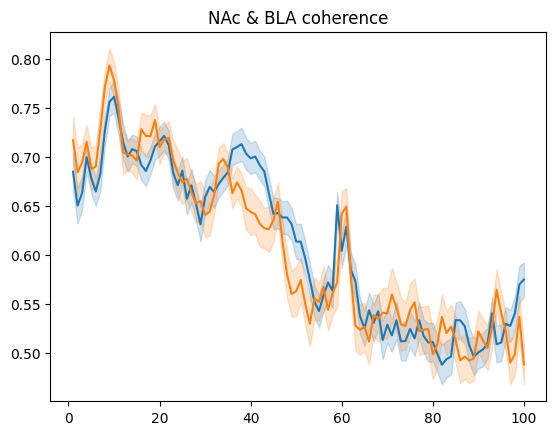

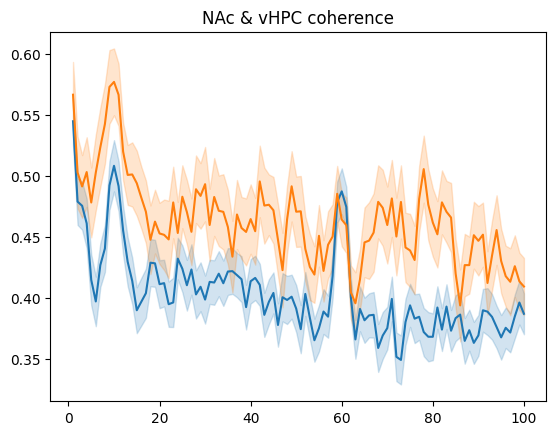

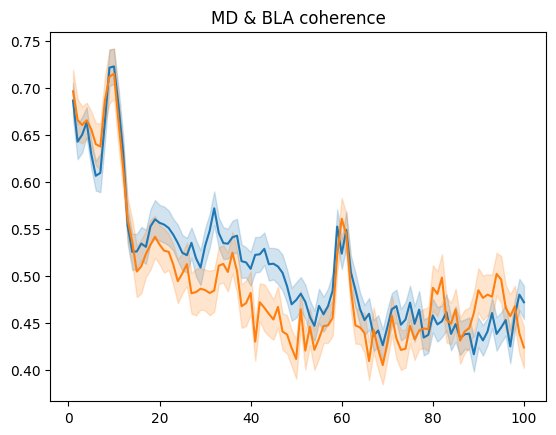

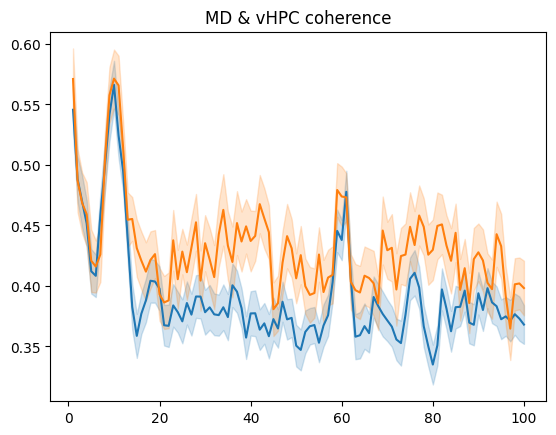

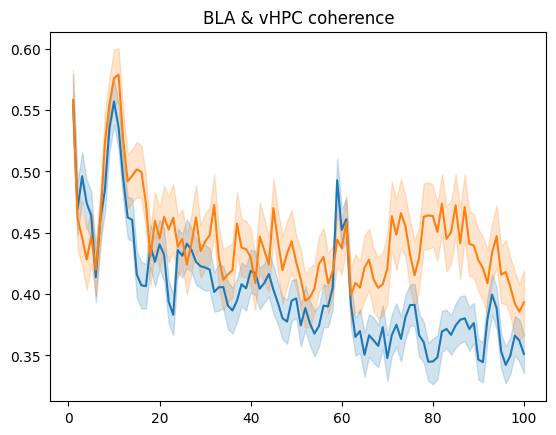

In [71]:
reload(lfplt)
reload(ee)
averages = lfplt.average_events(object_collection, events = ['novel mouse', 'familiar mouse'], mode = 'coherence')
lfplt.plot_coherence_spectrum(object_collection, averages)

(1810627,)


{'4-12Hz': array([-1.0079098 , -0.74129774, -0.72001751, ..., -1.58777076,
        -1.58210018, -1.57484699]),
 '12-30Hz': array([ 0.13251539, -0.10835356, -0.11746618, ...,  0.38886575,
         0.41882616,  0.399858  ]),
 '30-59Hz': array([-2.18432964, -1.90730752, -1.60792603, ...,  3.03114907,
        -2.9460189 , -2.57647419]),
 '59-80Hz': array([-0.79034545, -0.47694067, -0.03940818, ..., -0.99828934,
        -0.77427535, -0.63565146])}

In [ ]:
def generate_sine_wave(freq=1, amplitude=1, duration=1000, sample_rate=1000):
    """
    Generate a sine wave
    
    Parameters:
    freq: frequency of the sine wave in Hz
    amplitude: peak amplitude of the sine wave
    duration: length of the signal in seconds
    sample_rate: sampling frequency in Hz
    """
    # Create time array
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Generate sine wave
    sine_wave = amplitude * np.sin(2 * np.pi * freq * t)
    
    return t, sine_wave

t, sine_wave = generate_sine_wave(freq=4)

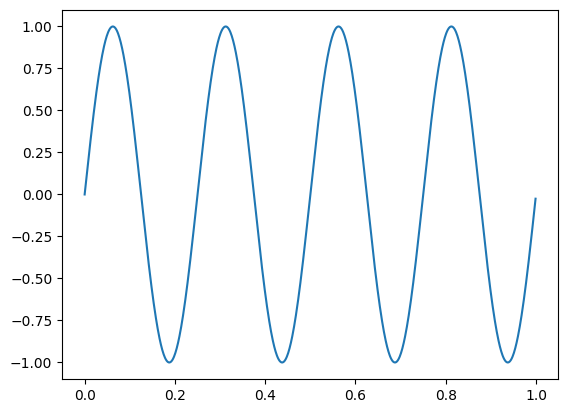

In [ ]:
plt.plot(t[0:1000], sine_wave[0:1000])

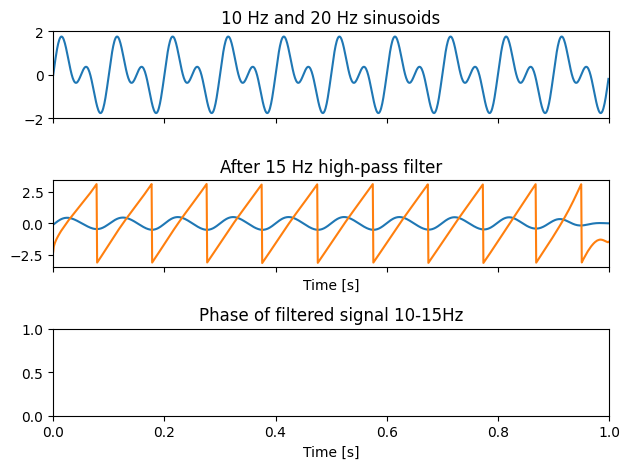

In [ ]:

t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

b, a = signal.butter(2, [10, 15], fs = 1000, btype='bandpass')
filtered = signal.filtfilt(b, a, x=sig)
ax2.plot(t, filtered)

ax2.set_title('After 15 Hz high-pass filter')
#ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [s]')
phase_dict = calculate_phase_at_frequencies(sig, 1000, [(10,15)])
ax2.plot(t, phase_dict['10-15Hz'])

ax3.set_title('Phase of filtered signal 10-15Hz')
ax3.set_xlabel('Time [s]')
plt.tight_layout()
plt.show()



(1000,)
1000


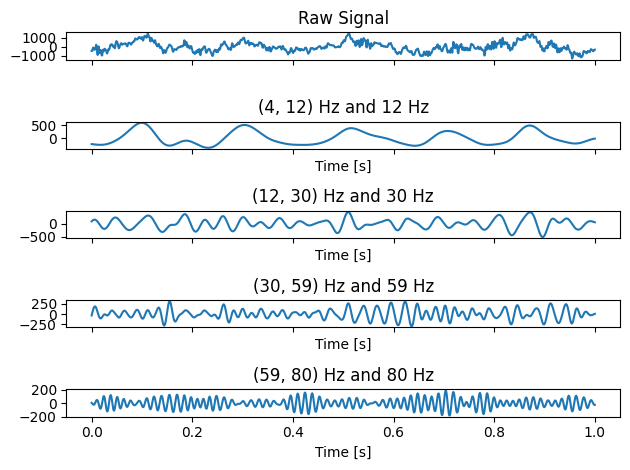

In [ ]:
sig = object_collection.recordings[0].traces[1000:2000,0]
print(sig.shape) # 1 second of data
freqs = [(4,12), (12,30), (30,59), (59,80)]

t = np.linspace(0,sig.shape[0]/1000,sig.shape[0])
print(len(t)) # 1 second
filter_sigs = []
for (low_freq, high_freq) in freqs:
    b, a = signal.butter(2, [low_freq, high_freq], fs = 1000, btype='bandpass')
    filtered = signal.filtfilt(b, a, x=sig)
    filter_sigs.append(filtered)
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex=True)
ax0.plot(t, sig)
ax0.set_title('Raw Signal')
ax1.plot(t, filter_sigs[0])
ax1.set_title(f'{freqs[0]} Hz and {freqs[0][1]} Hz')
ax1.set_xlabel('Time [s]')
ax2.plot(t, filter_sigs[1])
ax2.set_title(f'{freqs[1]} Hz and {freqs[1][1]} Hz')
ax2.set_xlabel('Time [s]')
ax3.plot(t, filter_sigs[2])
ax3.set_title(f'{freqs[2]} Hz and {freqs[2][1]} Hz')
ax3.set_xlabel('Time [s]')
ax4.plot(t, filter_sigs[3])
ax4.set_title(f'{freqs[3]} Hz and {freqs[3][1]} Hz')
ax4.set_xlabel('Time [s]')
plt.tight_layout()
plt.show()

In [ ]:
test_traces = object_collection.recordings[0].traces[:,0]



In [38]:
rec_phase_dict = {}
for recording in object_collection.recordings:
    region_dict = {}
    for region in range(recording.traces.shape[1]):
        traces = recording.traces[:,region]
        phase_dict = calculate_phase_at_frequencies(traces, 1000, [(4,12), (12,30), (30,59), (59,80)])
        region_dict[recording.brain_region_dict.inverse[region]] = phase_dict
    rec_phase_dict[recording.name] = region_dict


In [43]:
print(rec_phase_dict['22_object_merged.rec']['mPFC'].keys())

dict_keys(['4-12Hz', '12-30Hz', '30-59Hz', '59-80Hz'])


In [4]:
object_spikes.analyze(timebin=1)

All set to analyze


In [ ]:
hz_to_timebin = int(sampling_rate * 0.001 * timebin) #20000*.001 = 
bins = np.arange(1, last_timestamp + 2, hz_to_timebin)
spiketrain = np.histogram(timestamp_array, bins=bins)[0]


In [ ]:
timestamp_array = test_rec.timestamps_var.copy()
timestamp_array_new = np.insert(timestamp_array, 0, 1)
timestamp_array_new = np.insert(timestamp_array_new, 1, 20)

In [ ]:
bins = np.arange(1, 36212348, 20)
print(bins[0:10])
spiketrain = np.histogram(timestamp_array_new, bins=bins)[0]
print(spiketrain[0:20])
print(timestamp_array_new[0:10])

[  1  21  41  61  81 101 121 141 161 181]
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[   1   20  306 1409 1533 1622 1828 1907 2780 3080]


In [10]:

test_spikes = object_spikes.recordings[0].spiketrain
test_rec = object_spikes.recordings[0]
print(test_spikes.shape)
print(test_traces.shape)
print(object_spikes.timebin)
print(test_rec.timestamps_var[0], test_rec.timestamps_var[-1])
print(test_rec.timestamps_var[-1]/20)
print(test_rec.timestamps_var[0:10]/20)
print(test_spikes[0:100])
print(test_spikes[0:16])

(1810617,)
(1810627,)
1
306 36212348
1810617.4
[ 15.3   70.45  76.65  81.1   91.4   95.35 139.   154.   170.45 200.2 ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [5]:
behavior_dfs = {}
path = r"C:\Users\megha\Documents\Padilla-Coreano\homecage_social_ephys_vids\pilot2\boris\object\aggregated_csvs"
for file in os.listdir(path):
    if file.endswith(".csv"):
        behavior_dfs[file] = pd.read_csv(os.path.join(path, file))


In [ ]:
df

Observation id         Observation date  Description  \
0    phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
1    phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
2    phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
3    phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
4    phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
..                          ...                      ...          ...   
218  phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
219  phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
220  phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
221  phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   
222  phase7_22_object_converted  2025-03-06 14:35:39.709          NaN   

    Observation type                             Source  Time offset (s)  \
0         Media file  player #1:22_object_converted.mp4              0.0   
1         Media file  player #1:22_object_converted.mp4              0.0   
2         Media file  player #1:22_object_converted.mp4              0.0   
3         Media file  player #1:22_object_converted.mp4              0.0   
4         Media file  player #1:22_object_converted.mp4              0.0   
..               ...                                ...              ...   
218       Media file  player #1:22_object_converted.mp4              0.0   
219       Media file  player #1:22_object_converted.mp4              0.0   
220       Media file  player #1:22_object_converted.mp4              0.0   
221       Media file  player #1:22_object_converted.mp4              0.0   
222       Media file  player #1:22_object_converted.mp4              0.0   

     Coding duration  Media duration (s)  FPS (frame/s)       Subject  ...  \
0             1208.4            1810.667           15.0       subject  ...   
1             1208.4            1810.667           15.0  social_agent  ...   
2             1208.4            1810.667           15.0       subject  ...   
3             1208.4            1810.667           15.0       subject  ...   
4             1208.4            1810.667           15.0       subject  ...   
..               ...                 ...            ...           ...  ...   
218           1208.4            1810.667           15.0       subject  ...   
219           1208.4            1810.667           15.0       subject  ...   
220           1208.4            1810.667           15.0       subject  ...   
221           1208.4            1810.667           15.0       subject  ...   
222           1208.4            1810.667           15.0       subject  ...   

     Start (s)  Stop (s) Duration (s)          Media file name  \
0      601.200   601.200          NaN  22_object_converted.mp4   
1      601.400   601.667        0.267  22_object_converted.mp4   
2      602.200   603.467        1.267  22_object_converted.mp4   
3      605.400   606.399        0.999  22_object_converted.mp4   
4      606.400   607.400        1.000  22_object_converted.mp4   
..         ...       ...          ...                      ...   
218   1785.933  1786.599        0.666  22_object_converted.mp4   
219   1786.600  1786.733        0.133  22_object_converted.mp4   
220   1792.000  1792.400        0.400  22_object_converted.mp4   
221   1808.467  1809.199        0.732  22_object_converted.mp4   
222   1809.200  1809.600        0.400  22_object_converted.mp4   

     Image index start  Image index stop  Image file path start  \
0                 9018            9018.0                    NaN   
1                 9021            9025.0                    NaN   
2                 9033            9052.0                    NaN   
3                 9081               NaN                    NaN   
4                 9096            9111.0                    NaN   
..                 ...               ...                    ...   
218              26789      

In [36]:
behavior_dfs['41_object_BCNT.csv']

Observation id     Observation date  Description  \
0    41_object_BCNT  2025-03-09 15:44:54          NaN   
1    41_object_BCNT  2025-03-09 15:44:54          NaN   
2    41_object_BCNT  2025-03-09 15:44:54          NaN   
3    41_object_BCNT  2025-03-09 15:44:54          NaN   
4    41_object_BCNT  2025-03-09 15:44:54          NaN   
..              ...                  ...          ...   
146  41_object_BCNT  2025-03-09 15:44:54          NaN   
147  41_object_BCNT  2025-03-09 15:44:54          NaN   
148  41_object_BCNT  2025-03-09 15:44:54          NaN   
149  41_object_BCNT  2025-03-09 15:44:54          NaN   
150  41_object_BCNT  2025-03-09 15:44:54          NaN   

                                            Media file  Total length   FPS  \
0    /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
1    /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
2    /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
3    /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
4    /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
..                                                 ...           ...   ...   
146  /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
147  /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
148  /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
149  /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   
150  /Volumes/LAB WORK/Research Lab/BORIS/Mar 7/41_...       3661.46  15.0   

     Subject         Behavior  Behavioral category  Modifiers Behavior type  \
0    subject     mice back in                  NaN        NaN         POINT   
1    subject  sniffing object                  NaN        NaN         STATE   
2    subject  sniffing object                  NaN        NaN         STATE   
3    subject  sniffing object                  NaN        NaN         STATE   
4    subject  sniffing object                  NaN        NaN         STATE   
..       ...              ...                  ...        ...           ...   
146  subject  sniffing object                  NaN        NaN         STATE   
147  subject  sniffing object                  NaN        NaN         STATE   
148  subject  sniffing object                  NaN        NaN         STATE   
149  subject  sniffing object                  NaN        NaN         STATE   
150  subject  sniffing object                  NaN        NaN         STATE   

     Start (s)  Stop (s)  Duration (s)  Comment start  Comment stop  
0      610.705   610.705           NaN            NaN           NaN  
1      611.455   614.202         2.747            NaN           NaN  
2      614.704   617.455         2.751            NaN           NaN  
3      618.955   619.703         0.748            NaN           NaN  
4      622.452   623.705         1.253            NaN           NaN  
..         ...       ...           ...            ...           ...  
146   1734.102  1737.105         3.003            NaN           NaN  
147   1739.355  1740.604         1.249            NaN           NaN  
148   1744.354  1746.356         2.002            NaN           NaN  
149   1762.605  1763.856         1.251            NaN           NaN  
150   1809.106  1810.105         0.999            NaN           NaN  

[151 rows x 16 columns]

In [53]:
collection_seg_dict = {}
for filename, df in behavior_dfs.items():
    seg_dict = {}
    mouse_in = list(df[df['Behavior'] == 'mice back in']['Start (s)'])
    mouse_out = list(df[df['Behavior'] == 'mice taken out']['Start (s)'])
    try:
        media_duration = float(df['Media duration (s)'].unique())
    except KeyError:
        media_duration = np.nan
    if filename == '23_object_TBCN.csv':
        mouse_in.insert(0, 602)
        mouse_out.insert(0, 900)
        mouse_in.insert(1, 902)
        mouse_out.insert(1, 1201)
    if filename == '32_object_NBTC.csv': 
        mouse_in.insert(1, 922)
        mouse_in.insert(2, 1222)
        mouse_out.insert(1, 1222)
        mouse_out.insert(2,1521)
    if filename == '31_object_BNTC.csv':
        mouse_in.insert(0, 608)
        mouse_in.insert(2, 1213)
        mouse_out.insert(0, 906)
        mouse_out.insert(2,1521)
    print(media_duration)
    seg_1 = np.array([mouse_in[0], mouse_out[0]]) * 1000
    seg_2 = np.array([mouse_in[1], mouse_out[1]])*1000
    seg_3 = np.array([mouse_in[2], mouse_out[2]])*1000
    seg_4 = np.array([mouse_in[3], media_duration])*1000
    seg_0 = np.array([0, mouse_in[0]])*1000

    segs= [seg_1, seg_2, seg_3, seg_4]
    seg_dict = {}
    order_dict = {'T': 'novel object', 'B': 'familiar object', 'N': 'novel mouse', 'C': 'familiar mouse'}
    order = filename.split("_")[-1].split(".")[0]
    for i in range(len(order)):
        seg_dict[f'{order_dict[order[i]]}'] = segs[i]
    seg_dict['baseline'] = seg_0
    new_name = (filename.split("_")[0] + "_" + filename.split("_")[1] + "_merged.rec").lower()
    collection_seg_dict[new_name] = seg_dict

1810.667
1830.6
1830.867
1831.0
nan
1810.667


C:\Users\megha\AppData\Local\Temp\ipykernel_4784\1578292232.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  media_duration = float(df['Media duration (s)'].unique())


In [ ]:
 df_1 = df[df['Start (s)'] < mouse_out[0]]
    df_2 = df[(df['Start (s)'] > mouse_in[1]) &
            (df['Start (s)'] < mouse_out[1])]
    df_3 = df[(df['Start (s)'] > mouse_in[2]) &
            (df['Start (s)'] < mouse_out[2])]
    df_4 = df[(df['Start (s)'] > mouse_in[3])]

In [ ]:
type(test_spikes)
seg_1[0]

601200.0

In [ ]:
test_rec.unit_spiketrains.keys()

dict_keys(['64', '50', '8', '37', '63', '27', '19', '24', '59', '29', '32', '58', '16'])

In [ ]:
unit_test = test_rec.unit_spiketrains['64']
unit_test 

In [29]:
object_collection.analyze(timebin = 1)

AttributeError: 'LFPCollection' object has no attribute 'analyze'

In [44]:
events

NameError: name 'events' is not defined

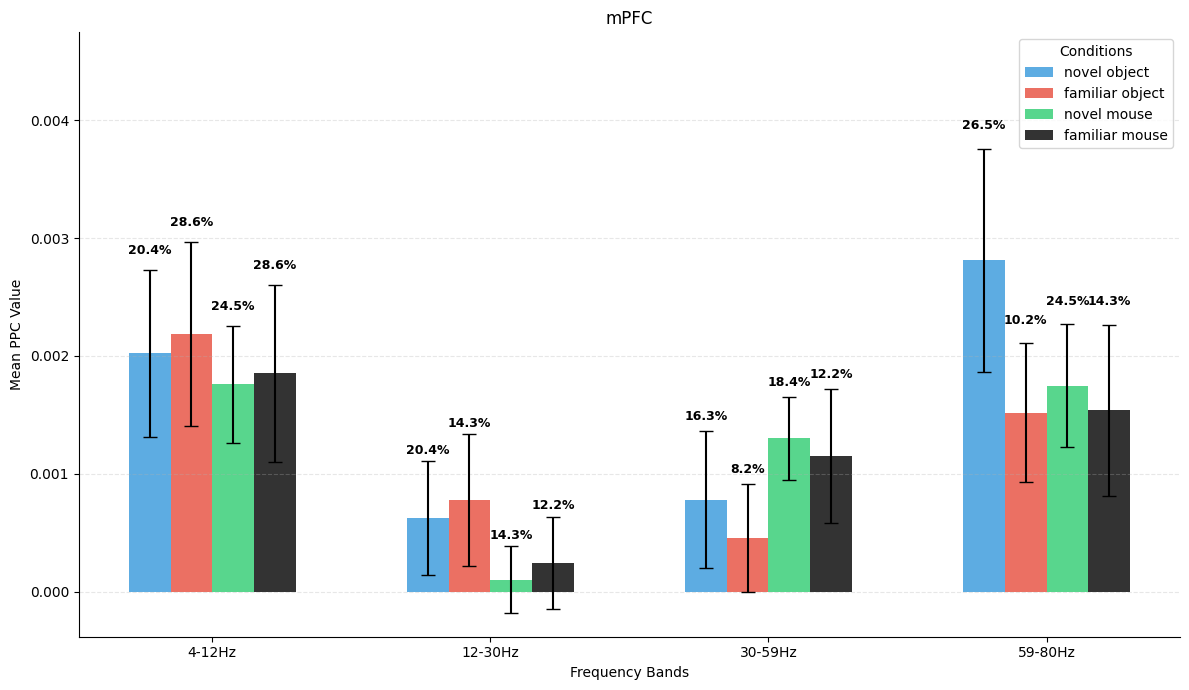

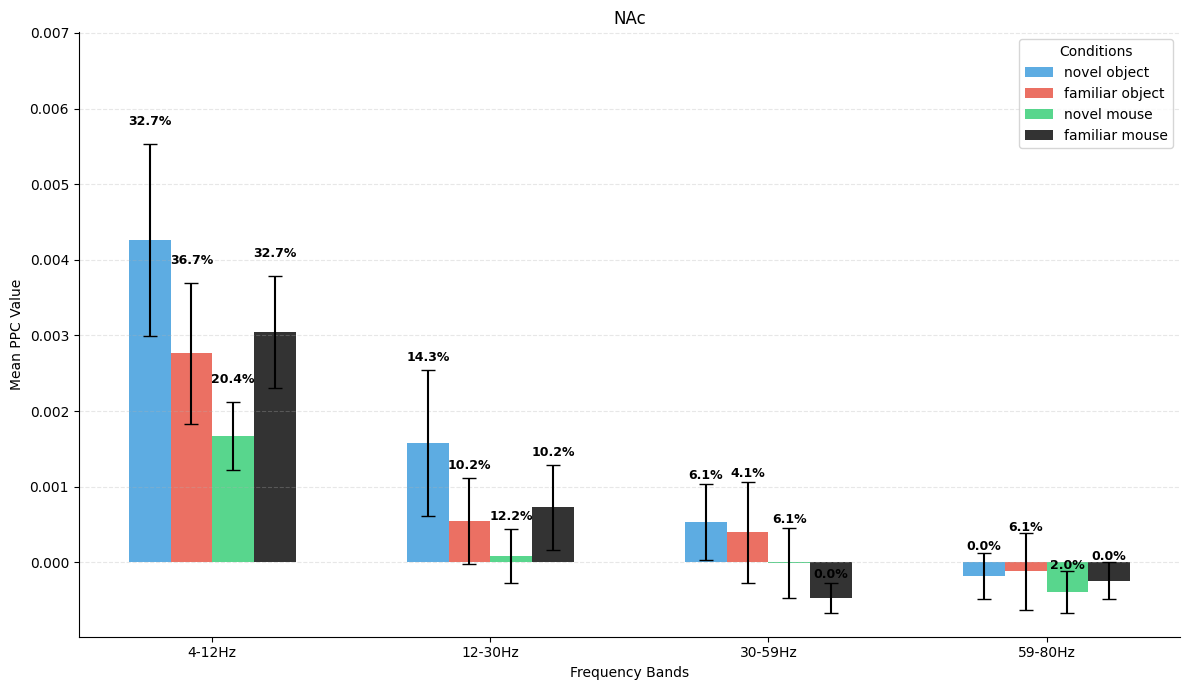

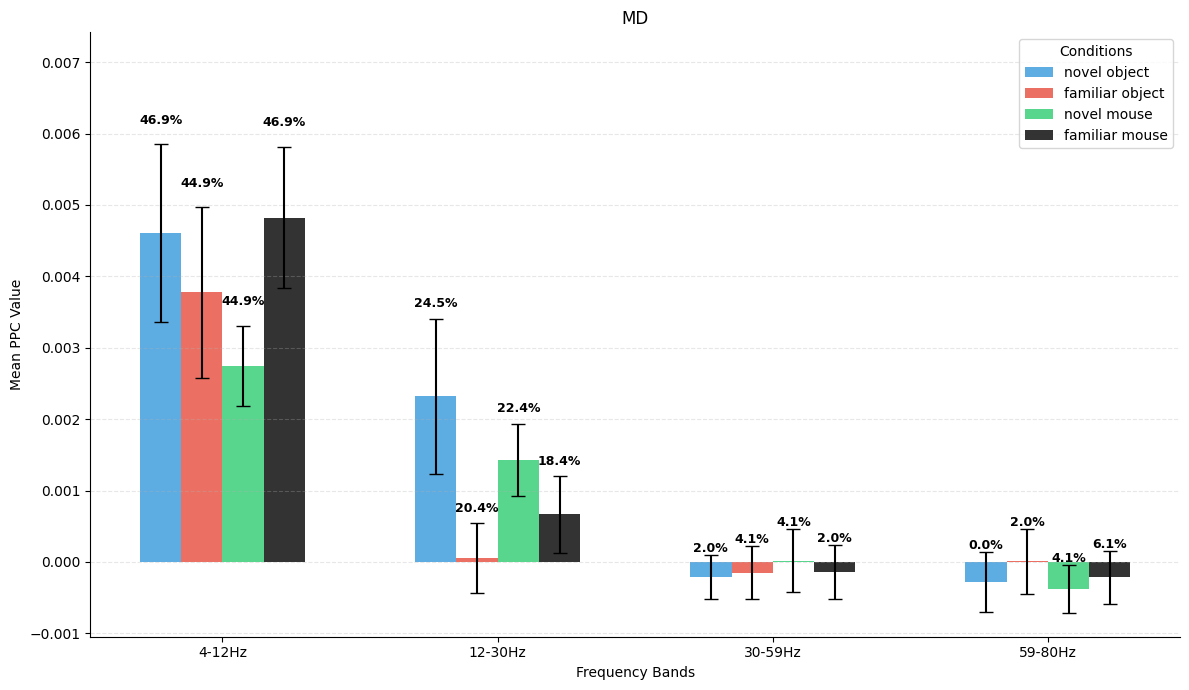

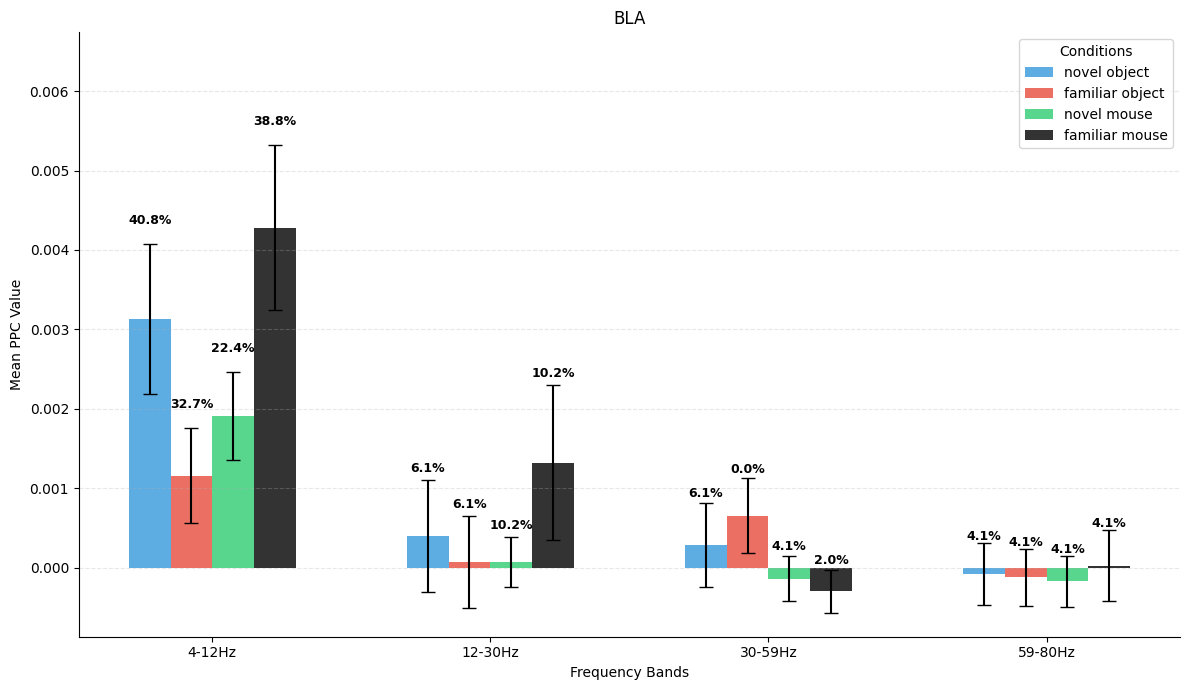

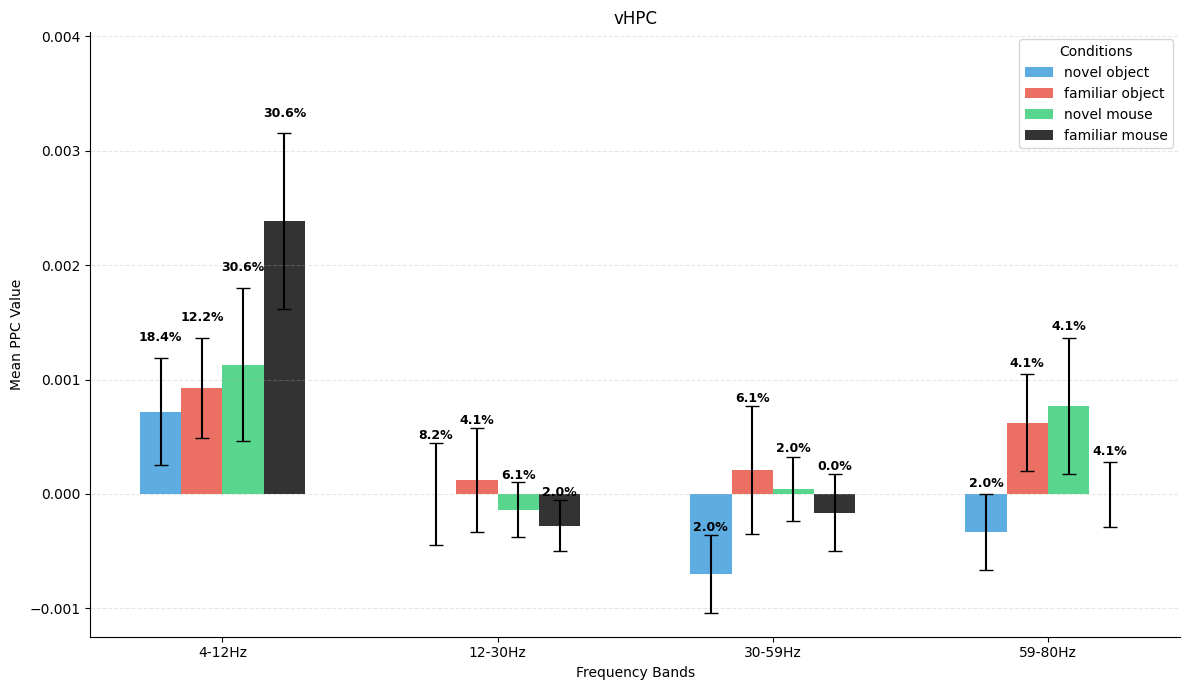

In [57]:
from scipy.stats import circmean
from astropy.stats import rayleightest
from scipy.stats import rayleigh
# Assuming we have these variables defined:
# cell_ts_off - spike timestamps
# Ph_OFF - a function that returns phases at given timestamps
# LFPinsoff - indices of LFP at spike times
# unit - current unit being analyzed
# PPCthetabla - array to store results
events = ['novel object', 'familiar object', 'novel mouse','familiar mouse']
freq_bands = ['4-12Hz', '12-30Hz', '30-59Hz', '59-80Hz']
for region in object_collection.brain_region_dict.keys():
    seg_ppc_dict = {}
    for event in events:
        ppc_dict = {}
        for freq_band in freq_bands:
            PPCs = []
            rayleighs = []
            for recording in object_spikes.recordings:
                for unit, spike_trains in recording.unit_spiketrains.items():
                    times = collection_seg_dict[recording.name][event]
                    values = rec_phase_dict[recording.name][region][freq_band]
                    try:
                        seg_spike_train = spike_trains[int(times[0]):int(times[1])]
                        seg_lfp_phase = values[int(times[0]):int(times[1])]
                    except (IndexError, ValueError):
                        seg_spike_train = spike_trains[int(times[0]):int(spike_trains.shape[0])]
                        seg_lfp_phase = values[int(times[0]):int(spike_trains.shape[0])]
                    if seg_spike_train.shape[0] != seg_lfp_phase.shape[0]:
                        shorter_len = min(seg_spike_train.shape[0], seg_lfp_phase.shape[0])
                        seg_spike_train = seg_spike_train[:shorter_len]
                        seg_lfp_phase = seg_lfp_phase[:shorter_len]
                                    
                    if sum(seg_spike_train) > 100:
                        # Extract spike phases
                        mask = seg_spike_train.astype(bool)
                        spike_phases = seg_lfp_phase[mask]
                

                        # Create matrices for all pairwise comparisons
                        temp1 = np.tile(spike_phases, (len(spike_phases), 1))
                        temp2 = temp1.T
                        # Calculate absolute circular distance between all pairs
                        
                        r = np.abs(np.angle(np.exp(1j*temp1)/np.exp(1j*temp2)))
                        # Create identity matrix with same dimensions
                        add_nans = np.eye(temp1.shape[0])
                        
                        # Replace ones with NaN
                        add_nans[add_nans == 1] = np.nan
                        
                        # Add NaNs to diagonal
                        r = r + add_nans
                        
                        # Calculate PPC
                        PPC = (np.pi - 2 * np.nanmean(np.nanmean(r))) / np.pi
                        p = rayleightest(spike_phases)
                        rayleighs.append(p)
                        # fig, ax = plt.subplots(1, 1)
                        # r = rayleigh.rvs(spike_phases)
                        # ax.hist(spike_phases, density=True, bins=20, histtype='stepfilled', alpha=0.2)
                        # ax.set_title(f'{unit}: PPC:{PPC}, p = {p}')
                        # plt.show()
                    else:
                        # Not enough spikes
                        rayleighs.append(np.nan)
                        PPC= np.nan
                    PPCs.append(PPC)
            ppc_array = np.array(PPCs)
            ppc_mean = np.nanmean(ppc_array)
            ppc_sem = sem(ppc_array, nan_policy='omit')
            percent_sig = np.sum(np.array(rayleighs) < .05)/len(rayleighs)
            ppc_dict[freq_band] = [ppc_mean, ppc_sem, percent_sig]
        seg_ppc_dict[event] = ppc_dict

    inner_keys = list(next(iter(seg_ppc_dict.values())).keys())
    outer_keys = list(seg_ppc_dict.keys())

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))

    # Define bar properties
    bar_width = 0.15
    opacity = 0.8
    index = np.arange(len(inner_keys))
    colors = ['#3498db', '#e74c3c', '#2ecc71', 'black', 'orange']  # Blue, Red, Green

    # Plot grouped bars for each outer key (group)
    for i, outer_key in enumerate(outer_keys):
        # Extract data for this group
        group_data = seg_ppc_dict[outer_key]
        means = [group_data[key][0] for key in inner_keys]
        sems = [group_data[key][1] for key in inner_keys]
        percentages = [group_data[key][2]*100 for key in inner_keys]
        
        # Calculate position for this group's bars
        position = index + (i - len(outer_keys)/2 + 0.5) * bar_width
        
        # Plot the bars for this group
        bars = ax.bar(position, means, bar_width, 
                    yerr=sems, capsize=5,
                    alpha=opacity, color=colors[i], 
                    label=outer_key)
        
        # Add percentage labels above each bar
        for j, bar in enumerate(bars):
            height = bar.get_height()
            label_height = height + sems[j] + max([seg_ppc_dict[k][inner_keys[j]][0] 
                                                for k in outer_keys]) * 0.05
            ax.text(bar.get_x() + bar.get_width()/2., label_height,
                    f'{percentages[j]:.1f}%', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Add labels, title and legend
    ax.set_xlabel('Frequency Bands')
    ax.set_ylabel('Mean PPC Value')
    ax.set_title(f'{region}')
    ax.set_xticks(index)
    ax.set_xticklabels(inner_keys)
    ax.legend(title='Conditions')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add some extra space for the labels
    plt.ylim(top=plt.ylim()[1] * 1.2)

    # Add a grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [54]:
collection_seg_dict.keys()

dict_keys(['22_object_merged.rec', '23_object_merged.rec', '31_object_merged.rec', '32_object_merged.rec', '41_object_merged.rec', '44_object_merged.rec'])

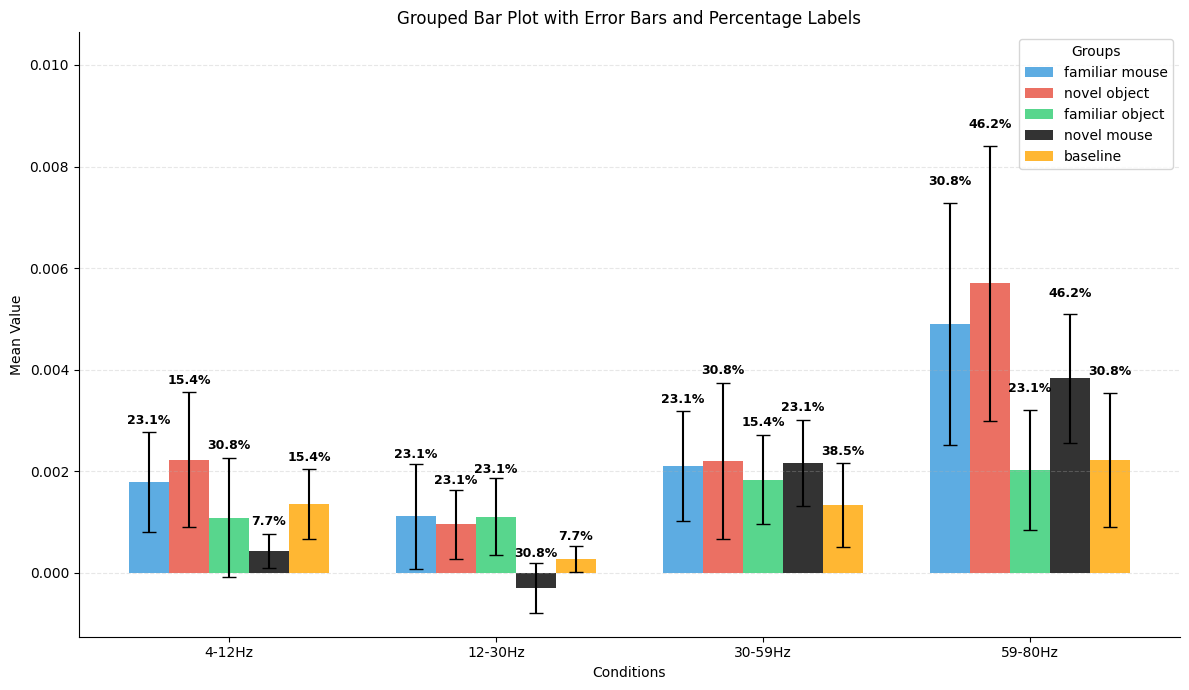

In [ ]:
print(len(PPCs), len(rayleighs))
for i in range(len(PPCs)):
    print(PPCs[i], rayleighs[i])

13 13
0.00010001557055035709 0.30439489119101787
0.0014620971946439352 0.009362697723260658
-0.001212173997876899 0.8506349147631085
0.0003639811330514989 0.26220792562612244
0.005508622714802042 0.00047982021998552865
-0.0011919109355202659 0.5994904016383147
0.0005415680387498231 0.06377965558886667
-1.284729979578931e-05 0.4224235194210383
nan nan
0.005425056172785061 0.14707965290884004
-7.881740185875484e-05 0.34628265172510225
nan nan
0.008706157024377797 0.04829748459949275


In [ ]:
temp1

array([[-1.51869277, -1.28610285, -1.05652665, ..., -2.70655095,
        -2.41646611, -2.3504281 ],
       [-1.51869277, -1.28610285, -1.05652665, ..., -2.70655095,
        -2.41646611, -2.3504281 ],
       [-1.51869277, -1.28610285, -1.05652665, ..., -2.70655095,
        -2.41646611, -2.3504281 ],
       ...,
       [-1.51869277, -1.28610285, -1.05652665, ..., -2.70655095,
        -2.41646611, -2.3504281 ],
       [-1.51869277, -1.28610285, -1.05652665, ..., -2.70655095,
        -2.41646611, -2.3504281 ],
       [-1.51869277, -1.28610285, -1.05652665, ..., -2.70655095,
        -2.41646611, -2.3504281 ]])

In [ ]:
temp2

array([[-1.51869277, -1.51869277, -1.51869277, ..., -1.51869277,
        -1.51869277, -1.51869277],
       [-1.28610285, -1.28610285, -1.28610285, ..., -1.28610285,
        -1.28610285, -1.28610285],
       [-1.05652665, -1.05652665, -1.05652665, ..., -1.05652665,
        -1.05652665, -1.05652665],
       ...,
       [-2.70655095, -2.70655095, -2.70655095, ..., -2.70655095,
        -2.70655095, -2.70655095],
       [-2.41646611, -2.41646611, -2.41646611, ..., -2.41646611,
        -2.41646611, -2.41646611],
       [-2.3504281 , -2.3504281 , -2.3504281 , ..., -2.3504281 ,
        -2.3504281 , -2.3504281 ]])

In [ ]:
np.tile(range(10), (10, 1))

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

c:\Users\megha\Documents\GitHub\diff_fam_social_memory_ephys\lfp\lfp_analysis\event_extraction.py:115: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)
c:\Users\megha\Documents\GitHub\diff_fam_social_memory_ephys\lfp\lfp_analysis\plotting.py:77: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(np.array(averages), axis=0)


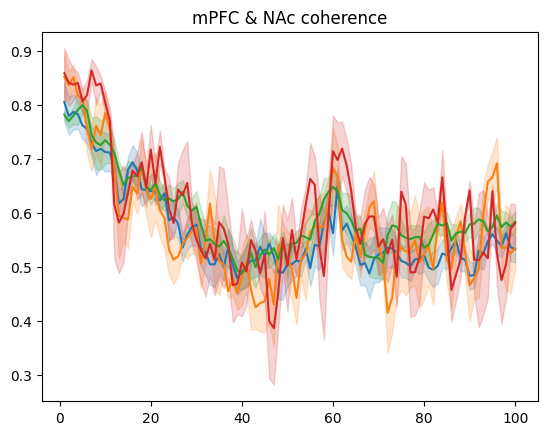

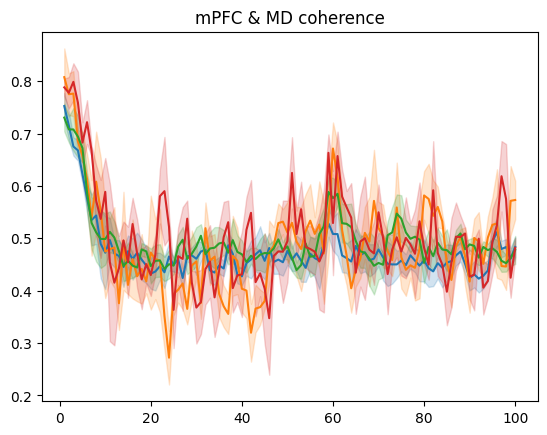

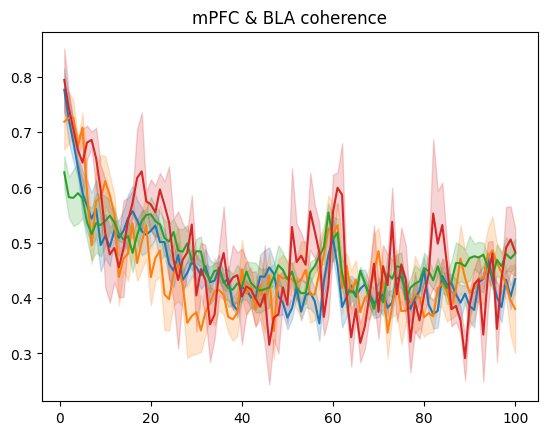

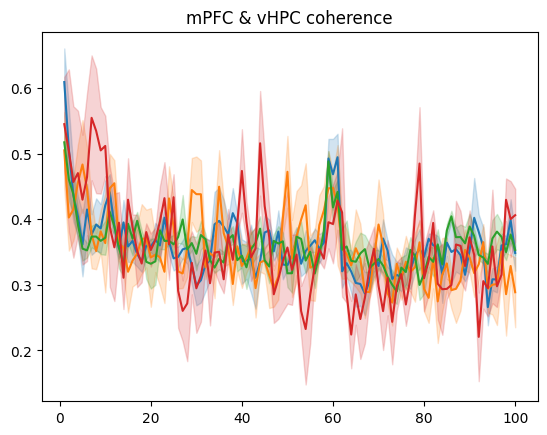

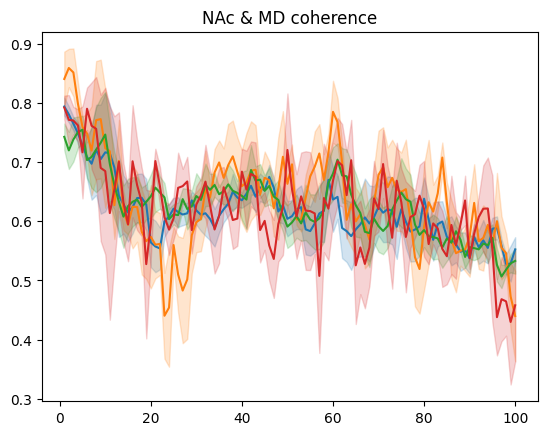

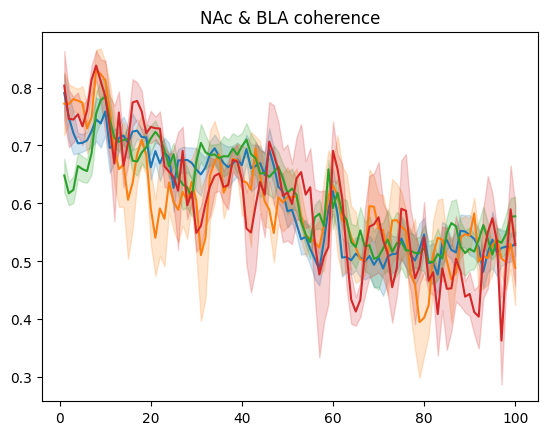

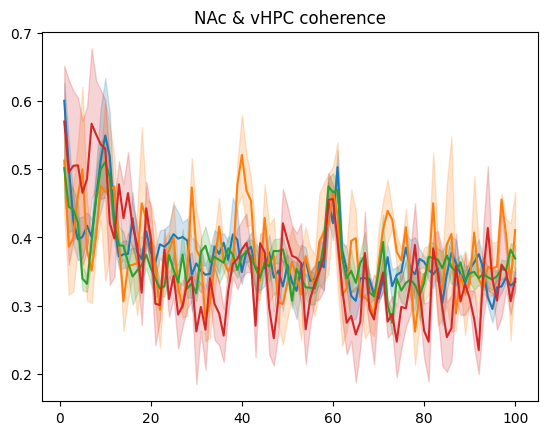

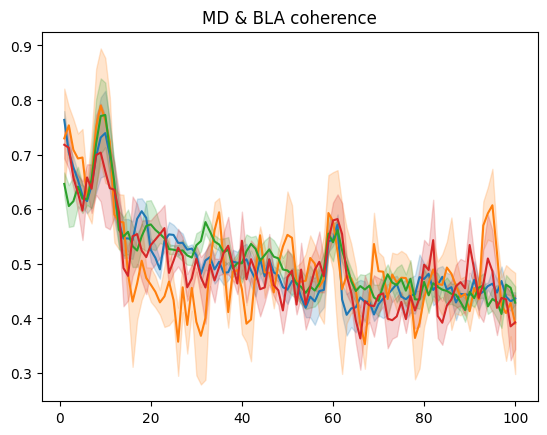

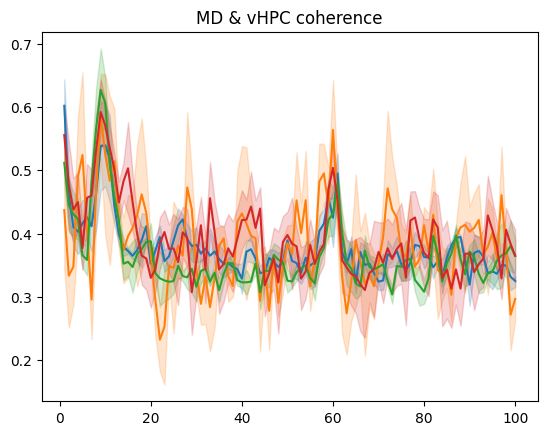

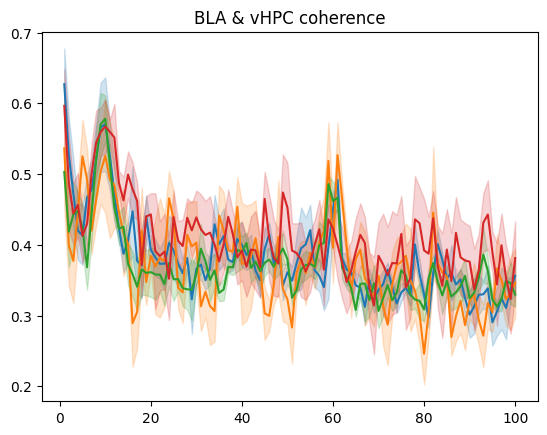

In [92]:
import lfp.lfp_analysis.event_extraction as ee
from importlib import reload
reload(lfplt)
reload(ee)
events = ['novel object', 'familiar object', 'novel mouse','familiar mouse']
coherence_average = ee.average_events(object_collection, events = events, mode = 'coherence')
lfplt.plot_coherence_spectrum(object_collection, coherence_average)